# Figures / analysis for flat slab paper

In [1]:
%pylab inline
import numpy as np

import seaborn as sns
import glob2
import pandas as pd
import h5py
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
import natsort
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import CubicSpline
import numpy as np
import pint

u = pint.UnitRegistry()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#dimensionalisation factors

velScale = 3.4482758620689656e-13*(3600*24*365)*100.  #cm/y
timeScale = 8.41e+18/(1e6*3600*24*365)
lengthScale = 2900. #km
stressScale =  11.890606*1e-6   #to MPa

stressScale

1.1890605999999999e-05

## Functions Required

In [3]:
def listify_data(unique_string, path):
    glob_str = path + '*' + unique_string + '*'
    files = natsort.natsort(glob2.glob(glob_str))
    #print(glob_str)
    #return files
    
    dataList = []
    for f in files:
        with h5py.File(f,'r') as hf:
            data = hf.get('data')
            dataList.append(np.array(data))
    return dataList


def get_along_strike(pts):
    dxs = np.diff(pts[:,0])
    dys = np.diff(pts[:,1])
    ds = np.sqrt(dxs**2 + dys**2)
    
    #pad the first point
    return np.append(ds[0], ds) , np.cumsum(np.append([0.], ds)) #front and back pad these arrays


def curvature_splines(x, y):
    """Calculate the signed curvature of a 2D curve at each point
    using interpolating splines.
    Parameters
    ----------
    x,y: numpy.array(dtype=float) shape (n_points, )
    """

    fx = CubicSpline(x, x)
    fy = CubicSpline(x, y)
    #print(np.sqrt(std))

    #x1 = fx.derivative(1)(x)
    #x2 = fx.derivative(2)(x)
    y1 = fy.derivative(1)(x)
    y2 = fy.derivative(2)(x)
    #curvature = (x1* y2 - y1* x2) / np.power(x1** 2 + y1** 2, 1.5)
    curvature = (y2) / np.power(1 + y1** 2, 1.5)

    return curvature, fx, fy, y1

## Setup filter

In [4]:
import scipy.signal as signal
N  = 2    # Filter order
# Cutoff frequency `Wn` is normalized from 0 to 1, 
#where 1 is the Nyquist frequency, pi radians/sample.

#Wn = 0.19 #
#Wn1 = 0.025 #

Wn = 0.26 #
Wn1 = 0.101 #

B, A = signal.butter(N, Wn, output='ba')
B1, A1 = signal.butter(N, Wn1, output='ba')



In [5]:
i = 87               #timestep to analyse


## Dataframe with plate boundary location

In [6]:
def get_dataframe():
    #file_ = '../models/results/A/20/values/tect_model_data.npz'
    file_ = '../models/results/B/16/values/tect_model_data.npz'
    out = np.load(file_)
    d = dict(out)
    df = pd.DataFrame.from_dict(d)
    return df 

df = get_dataframe()

In [7]:
trenchLoc = (df['(2, 3)'].iloc[i] - 30./lengthScale)*lengthScale
print(trenchLoc)

-510.03650997091023


## Load data

In [8]:
#loads slab midplane points, all timesteps

mppoints = listify_data('midplane**', '../models/results/{}/{}/**/'.format('B', 16))

In [9]:
depthlimit = 1. - (250/2900.)   #depth cutoff (avoids dealing with overturned slab)

In [10]:
#order the data 

indexes = np.argsort(mppoints[i][:,0])
NP = 4    #only us every Nth point
sortedData = mppoints[i].copy()[indexes]
sortedData = sortedData[sortedData[:,1] > depthlimit] #remove deeper points
sortedData = sortedData[sortedData[:,0] > -0.5] #remove points away from the trench
sortedData = sortedData[::NP,:]
ds, ds_cum = get_along_strike(sortedData)
dsMean = ds.mean()


In [11]:
# Second, apply the filter
print(dsMean*lengthScale)
print((1./Wn)*(dsMean*lengthScale))  #wavelength of filter 1
print((1./Wn1)*(dsMean*lengthScale)) #wavelength of filter 2

2.5633726324574764
9.85912550945183
25.379927054034418


# Estimate the curvature, curvature gradient

In [12]:
fy = CubicSpline(sortedData[:,0], sortedData[:,1])

y1_ = fy.derivative(1)(sortedData[:,0])
y2_ = fy.derivative(2)(sortedData[:,0])
c_ = (y2_) / np.power(1 + y1_** 2, 1.5)

c_F = signal.filtfilt(B,A, c_)

dxMean = ds.min()*1

cx_0 = np.gradient(c_, dxMean)
cx_F= signal.filtfilt(B,A, cx_0)
cx_F1= signal.filtfilt(B1,A1, cx_0)

## Plot the curvatire gradient, check filters

Text(-270,5e-11,'($m^{-2}$)')

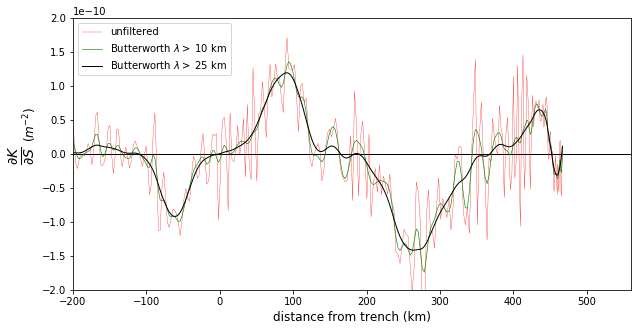

In [13]:
f, ax = plt.subplots(figsize=(10, 5))
ax.plot(sortedData[::1,0]*2900 - trenchLoc, cx_0*(1./2900e3**2),c = 'r', label='unfiltered', lw = 0.3)
ax.plot(sortedData[::1,0]*2900 - trenchLoc, cx_F*(1./2900e3**2), 
        c = 'g', lw = 0.6, label=r'Butterworth $\lambda >$ 10 km')
ax.plot(sortedData[::1,0]*2900 - trenchLoc, cx_F1*(1./2900e3**2), 
        c = 'k', lw = 1, label=r'Butterworth $\lambda >$ 25 km')


ax.set_xlabel('distance from trench (km)', size = 12)
ax.set_ylabel(r'$\frac{\partial{K}}{\partial{S}}$ ', size = 20)


ax.hlines(0, -200, 600, lw=1)
#ax.plot(sortedData[::n,0], cxF)
ax.set_ylim(-2e-10, 2e-10)
ax.set_xlim(-200, 560)
ax.legend(loc = 2)

ax.text(-270, 0.5e-10, r'($m^{-2}$)', size = 12, rotation=90)

In [14]:
#f.savefig('filtering.png', dpi=400, bbox_inches='tight')

## Save midplane gradient data

In [15]:
midPlaneCurv = np.column_stack( ( 2900.*sortedData[:,0], c_F *(1./2900)  ))
midPlaneCurvGrad = np.column_stack( ( 2900.*sortedData[:,0], cx_F1*(1./2900**2) ))
dimData = np.column_stack(( sortedData[:,0]*2900.0, (1. - sortedData[:,1])*2900.0 ))

#np.savetxt('midPlane.csv', dimData, delimiter=',')
#np.savetxt('curv.csv', midPlaneCurv , delimiter=',')
#np.savetxt('curvGrad.csv', midPlaneCurvGrad, delimiter=',')


## Load the subduction interface data


In [16]:
## Get / save interface 

interfaceOffsetKm = 7.
ifpoints = listify_data('interface**', '../models/results/{}/{}/**/'.format('B', 16))

indexes = np.argsort(ifpoints[i][:,0])
intData = ifpoints[i].copy()[indexes]


#dimIntData0 = np.column_stack((2900.*intData[:,0], 
#                            2900.*(1. - intData[:,1]) - 0. ))
#dimIntData = np.column_stack((2900.*intData[:,0], 
#                           2900.*(1. - intData[:,1]) - interfaceOffsetKm))





#save dimensional interface data
#np.savetxt('slabTop.csv', dimIntData, delimiter=',')


## Set UW mesh, and load fields

In [17]:
import os

import numpy as np
import underworld as uw
from underworld import function as fn
import glucifer


In [18]:
yres = 192
xres = int(yres  * 6)
elementType = 'Q1/dQ0'



mesh = uw.mesh.FeMesh_Cartesian(elementType = (elementType),
                                 elementRes  = (xres, yres)) 

meshFile = natsort.natsort(glob2.glob('/workspace2/flat_slab/B/16/mesh**.h5'))

mesh.load(meshFile[0])
#Note that when you read in a deformed mesh file, the extents are not correct


scalarField   = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
tempField   = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
strainField   = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )


In [19]:
#sigFiles = natsort.natsort(glob2.glob('/workspace2/flat_slab/A/6/sigSS**.h5'))
sigFiles = natsort.natsort(glob2.glob('/workspace2/flat_slab/B/16/sigSS**.h5'))
sfile = sigFiles[i]

#tempFiles = natsort.natsort(glob2.glob('/workspace2/flat_slab/A/6/temp**.h5'))
tempFiles = natsort.natsort(glob2.glob('/workspace2/flat_slab/B/16/temp**.h5'))
tfile = tempFiles[i]

#strain rate 
#eFiles = natsort.natsort(glob2.glob('/workspace2/flat_slab/B/16/eSS**.h5'))
#efile = eFiles[i]
#efile

In [20]:
scalarField.load(sfile)
tempField.load(tfile)
#strainField.load(efile)

In [21]:
#fig = glucifer.Figure(figsize=(960,300) )
#fig.append( glucifer.objects.Surface(mesh, tempField,  onMesh=True))
#fig.append( glucifer.objects.Mesh(mesh))

#fig.show()

## Do slab top properly

In [22]:

import sys

#this does't actually need to be protected. More a reminder it's an interim measure
sys.path.append('../../UWsubduction/')
import UWsubduction as usub

#mesh=None
velocityField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=2)
slabTopI2d = usub.interface2D(mesh, velocityField, intData[:,0], intData[:,1], 1.0, 1.0)

In [23]:
dslength = 7./2900
slabTopRef = slabTopI2d.swarm.particleCoordinates.data[:]
slabTopCorrect = slabTopI2d.swarm.particleCoordinates.data[:] - slabTopI2d.director.data[:]*dslength


dimIntData0 = np.column_stack((2900.*slabTopRef[:,0], 
                            2900.*(1. - slabTopRef[:,1]) - 0. ))
dimIntData = np.column_stack((2900.*slabTopCorrect[:,0], 
                           2900.*(1. - slabTopCorrect[:,1])))





#save dimensional interface data
#np.savetxt('slabTop.csv', dimIntData, delimiter=',')
#np.savetxt('slabTop2.csv', _dimIntData, delimiter=',')
#np.savetxt('slabTop2.csv', _dimIntData, delimiter=',')

In [24]:


dimIntData0 = np.column_stack((2900.*slabTopRef[:,0], 
                            2900.*(1. - slabTopRef[:,1]) - 0. ))
dimIntData = np.column_stack((2900.*slabTopCorrect[:,0], 
                           2900.*(1. - slabTopCorrect[:,1])))


#np.savetxt('slabTop.csv', slabTopCorrect, delimiter=',')

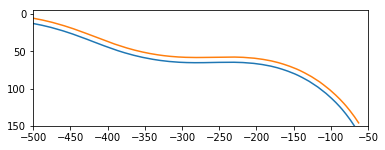

In [25]:
fig, ax = plt.subplots()

ax.plot(dimIntData0[:,0], dimIntData0[:,1])
ax.plot(dimIntData[:,0], dimIntData[:,1])

ax.set_ylim(150, -5)
ax.set_xlim(-500, -50)
ax.set_aspect('equal')

## Load earthquake data

In [26]:
dfEQ = pd.read_csv('./analysis_data/pps.csv')
dfEQW = dfEQ[dfEQ.sector == 'western'].copy()
dfEQW['mNorm'] = (dfEQW.m - dfEQW.m.min())/(dfEQW.m.max()- dfEQW.m.min())
dfEQE = dfEQ[dfEQ.sector == 'eastern']

dfEQ.head(3)

,id,distance,adj.depth,depth,m,temp,adj.temp,stress,adj.stress,sector
0,1,102.327159,-35.000000,-35.0,5.5,224.12,224.12,-0.15,-0.15,eastern
1,2,104.339079,-35.000000,-35.0,5.5,219.20,219.20,0.08,0.08,eastern
2,3,247.412883,-84.265221,-79.0,5.0,673.72,805.78,95.78,-80.86,western


## Plate age at trench 

In [27]:
times = np.linspace(0,35., 100)
vp =  np.linspace(9, 3., 100)
vr = 2.
plateLength = abs(df['(1, 2)'][i]*2900 - trenchLoc) - 30. #correction for MOR loc
ageAtFlat = df.timeAtSave.iloc[i]*timeScale

vp_r =  vp - vr #sp velocity on moving trench ref frame

vp *= 10 #factor of 10 converts from cm/y to km/myr
vp_r *= 10 

vgrad = (vp[-1] - vp[0])/times[-1]
int_1 = 0.5*vgrad* times**2 + vp[0]*times
int_2 = 0.5*vgrad* times**2 + vp_r[0]*times

distatT = int_2[np.argmin(np.abs(times - ageAtFlat))]
refDist = distatT - plateLength
ageSlab = ageAtFlat - times[np.argmin(np.abs(int_2 - refDist ))]

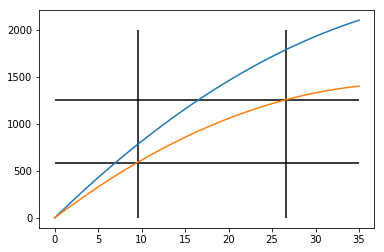

In [28]:
fig, ax = plt.subplots()
ax.plot(times, int_1)
ax.plot(times, int_2)
ax.hlines(refDist ,0, 35 )
ax.hlines(distatT ,0, 35 )

ax.vlines(ageAtFlat, 0, 2000)
ax.vlines(times[np.argmin(np.abs(int_2 - refDist ))], 0, 2000)

In [29]:
print(ageSlab)
print(ageAtFlat)

17.0488469549
26.5943015004


## Convergence velocity

In [30]:
vP = (9 - 3)*(1. - ageAtFlat/35.) + 3.
print(vP  + 2)

6.44097688565


In [31]:
np.sqrt(2)*25

35.355339059327378

## Lithospheric thickness

In [32]:
age = 20.*1e6*365*24*3600.
diff  = 1e-6
potentialTemp = 1400.

ageYoung = 10.*1e6*365*24*3600.
ageOld = 30.*1e6*365*24*3600.

In [33]:
from scipy.special import erfinv

z = (erfinv((650)/potentialTemp))*2.*np.math.sqrt(diff*age)
z

21995.767798749221

In [34]:
zs = np.linspace(0, 80e3, 1000)
TsZRef = [np.math.erf(z/(2.*np.math.sqrt(diff*age)) )*potentialTemp for z in zs]
TsZYoung = [np.math.erf(z/(2.*np.math.sqrt(diff*ageYoung)) )*potentialTemp for z in zs]
TsZOld = [np.math.erf(z/(2.*np.math.sqrt(diff*ageOld)) )*potentialTemp for z in zs]

In [35]:
index700 = np.argmin(np.abs(np.array(TsZRef) - 700.))
d70 = zs[index700]
d70

23943.943943943945

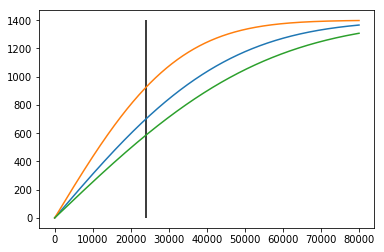

In [36]:
fig, ax = plt.subplots()
ax.plot(zs,TsZRef )
ax.plot(zs,TsZYoung )
ax.plot(zs,TsZOld )
ax.vlines(d70, 0, 1400.)

## EQ recurrence

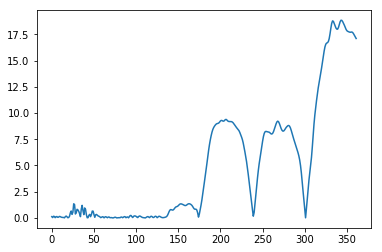

In [44]:
#10e-11
blok = -150
plt.plot(np.abs(c_F[50:-50]))

In [41]:
#get typical values for strain rate etc
blok = -150
#dimCurvature = y3[blok:-blok].min()*(1./2900e3**2)

dimCurvatureGrad =  cx_F1[-blok:blok].min()*(1./2900e3**2)

curvMin = np.abs(c_F[50:-50]).max()*(1./2900e3)
rocMin = 1/curvMin
dimCurvatureGradEst = 1./(rocMin**2)

#invert the Buffett relationship between Rc and Ks
rocEst = np.sqrt(1./abs(dimCurvatureGrad))
ypos = 15e3
refBendStrainRate = abs(dimCurvatureGrad*(5*u.centimeter/u.year).to_base_units()*ypos).magnitude
effVisc  = 200e6/(2*refBendStrainRate)
slabPullStress = 200e6 
stretchRateAtEffVisc = slabPullStress/(2.*effVisc ) 

dimCurvatureGrad , rocMin, rocEst, refBendStrainRate, effVisc, stretchRateAtEffVisc
#kostrov strain rate,
#if all strain was released seismogenically by Peubla-sized events, 
#what is the recurrence interval per eqVolume
#http://ds.iris.edu/spud/momenttensor/14300411
#eq rupture volume based on: "Bend Faulting at the Edge of a Flat Slab: The 2017 Mw7.1 Puebla-Morelos, Mexico Earthquake"


(-9.209195547255722e-11,
 153894.33687173942,
 104205.14268106372,
 2.1887102267119516e-15,
 4.5689008430425106e+22,
 2.1887102267119516e-15)

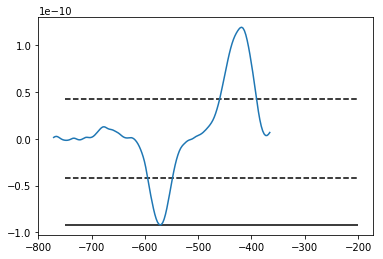

In [75]:
fig, ax = plt.subplots()
ax.plot(sortedData[-blok:blok,0]*2900 ,cx_F1[-blok:blok]*(1./2900e3**2))
#dimCurvature
ax.hlines(dimCurvatureGrad , -750, -200)
ax.hlines(dimCurvatureGradEst , -750, -200, linestyles='--')
ax.hlines(-1.*dimCurvatureGradEst , -750, -200, linestyles='--')

## Estimates of strain rate, elastic stresses etc

Text(0.5,0,'distance from slab middle line, kms')

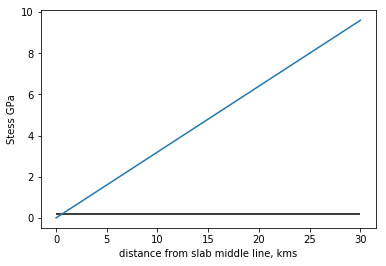

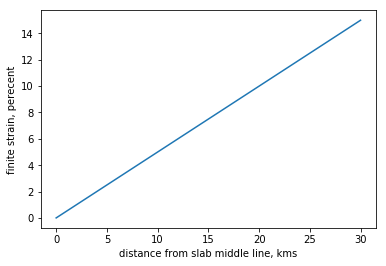

In [41]:

rigidity = 3e11 #dyne-cm 
scalarMom = 6.391e26
volumeOfEq = 100*30e3*100*30e3*100*60e3 #in centimetres to match dyne-cm convention
eqStrain = scalarMom/(2*rigidity*volumeOfEq)
eqRecurrence = ((eqStrain/refBendStrainRate)*u.seconds).to(u.years)

rocEst2 = 200e3
E =  60e9 #basalt
poisson = 0.25
Ep = E/(1. - poisson**2)
y = np.linspace(0, 30e3, 1000)
sigElast = Ep*y/rocEst2        #stress going from no flat to rocEst2, as a function of y

fig, ax = plt.subplots()
ax.plot(y/1000., sigElast/1e9)
ax.hlines(200e6/1e9, 0, 30)

ax.set_ylabel('Stess GPa')
ax.set_xlabel('distance from slab middle line, kms')

fig, ax = plt.subplots()
ax.plot(y/1000., 100*y/rocEst2) #stress going from no flat to rocEst2, hundred is for percent 

ax.set_ylabel('finite strain, perecent')
ax.set_xlabel('distance from slab middle line, kms')




In [42]:
yieldIndex = np.argmin(np.abs((sigElast/1e6) - 200))
print(y[yieldIndex]) #half-width of elastic core, meters

630.630630631


# Elasto-plastic length scale

In [84]:
KsEst = 1./(100e3**2) #characteristic curvature gradient from Buffett, also very similar to our model KsEst = 10e-11 #similar to our model

yEst= 20e3          #distance from midplane
yieldStess = 100e6
ds = 2.*yieldStess/(Ep*yEst*KsEst) #distance over which plastic limit is reached
ds #in meters

1562.5

## Simulating flat slab rollback 

In [ ]:
#Interface
dimIntDataScaled = dimIntData.copy()
mask = (dimIntDataScaled[:,0] -  trenchLoc) > 300.
dimIntDataScaled[mask,0] = dimIntDataScaled[mask,0].min() +  (dimIntDataScaled[mask,0] - dimIntDataScaled[mask,0].min()) * 0.45

#midplane
dimDataScaled = dimData.copy()
mask = (dimDataScaled[:,0] -  trenchLoc) > 290.

dimDataScaled[mask,0] = dimDataScaled[mask,0].min() +  (dimDataScaled[mask,0] - dimDataScaled[mask,0].min()) * 0.4

In [ ]:
#dimDataScaled

In [ ]:
#np.sqrt(31.819**2 + 31.819**2)

In [ ]:
fy = CubicSpline(dimDataScaled[:,0]/2900., 2900. - dimDataScaled[:,1]/2900.)
y1_ = fy.derivative(1)(dimDataScaled[:,0]/2900.)
y2_ = fy.derivative(2)(dimDataScaled[:,0]/2900.)
c_ = (y2_) / np.power(1 + y1_** 2, 1.5)

#c_F = gaussian_filter(c_, 5)
_c_F = signal.filtfilt(B1,A1, c_)

dxMean = ds.min()*1

_cx_0 = np.gradient(c_, dxMean)
_cx_F1= signal.filtfilt(B1,A1, _cx_0)

In [ ]:
#np.sqrt((308 - 290)**2  + (103- 62)**2)

In [ ]:
import matplotlib.patches as patches

#fig, ax = plt.subplots(figsize=(20,5))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20,15))
ax1.plot(dimIntData[:,0] - trenchLoc, dimIntData[:,1], 
         c = 'k', label = 'model slab top', ls = '-.')
ax1.plot(dimIntDataScaled[:,0] - trenchLoc, dimIntDataScaled[:,1],
         c = 'r', label = 'slab top w/ rollback', ls = '-.')
ax1.plot(dimData[:,0] - trenchLoc, dimData[:,1], c = 'k', label = 'model mid plane')
ax1.plot(dimDataScaled[:,0] - trenchLoc, dimDataScaled[:,1], c = 'r', label = 'model mid plane w/ rollback')


#ax.vlines(-0.1890954*2900., 0., 140)
ax1.set_ylim(160, 30)
ax1.set_xlim(150, 450)
ax1.set_aspect('equal')
#-0.1890954

ax1.add_patch(
    patches.Arrow(
        400,            # x
        100,            # y
        -50,            # dx
        0,            # dy
        width=15,      # optional - defaults to 1.0
        color = 'r'
    )
)


ax1.add_patch(
    patches.Arrow(
        448,            # x
        100,            # y
        -40,            # dx
        0,            # dy
        width=10,      # optional - defaults to 1.0
        color = 'k'
    )
)


ax1.plot([290,305], [56,71], lw = 2, c='g', ls = '--', label = 'approx Puebla rupture')


ax1.add_patch(patches.Circle((293,103), radius=45, fill=False))

#ax1.plot([290,308], [103, 62], lw = 3, c = 'k')
ax1.text(250, 103, 'min radius of curvature 45 km',  fontsize=12)

ax1.legend(fontsize = 'x-large', loc = 3)


ax1.set_ylabel('depth (km)', size = 25)
trenchLoc = -510.

ax2.plot(dimData[::1,0] - trenchLoc, -1.*(cx_F1*(1./2900e3**2))/2e-10, 
       c = 'k', lw = 2,  label = r'$\frac{\partial{K}}{\partial{S}}$ ')

ax2.plot(dimData[::1,0] - trenchLoc, -1.*(c_F*(1./2900e3))/10e-6, c = 'k',
        lw = 2,ls = '--', label = r'$K$')

ax2.plot(dimDataScaled[::1,0] - trenchLoc, -1.*(_cx_F1*(1./2900e3**2))/2e-10, 
       c = 'r', lw = 2,  label = r'$\frac{\partial{K}}{\partial{S}}$ ')

ax2.plot(dimDataScaled[::1,0] - trenchLoc, -1.*(_c_F*(1./2900e3))/10e-6, c = 'r',
        lw = 2,ls = '--', label = r'$K$')

ax2.legend(loc = 2, fontsize = 'x-large')
ax2.hlines(0, -200, 560, lw=1)
ax2.vlines(290, -1.1, 1.1, lw=2, colors='g', linestyles='--')

ax2.set_ylim(-2., 2.5)
#ax2.set_xlim(-200, 450)

ax2.set_xlabel('distance from trench (km)',  size = 25)



In [ ]:
#fig.savefig('corrected_profile.png', dpi=300, bbox_inches='tight')

In [20]:
#ax1.text?

In [ ]:
#np.savetxt('slabTop.csv', dimIntData, delimiter=',')
#np.savetxt('slabTopCorrected.csv', dimIntDataScaled, delimiter=',')

In [ ]:
#np.savetxt('midPlane.csv', dimData, delimiter=',')
#np.savetxt('midPlaneCorrected.csv', dimDataScaled, delimiter=',')

In [ ]:
#midPlaneCurvCorrected = np.column_stack( ( dimDataScaled[:,0], -1.*(_c_F*(1./2900e3)) ))
#midPlaneCurvGradCorrected = np.column_stack( ( dimDataScaled[:,0], -1.*(_cx_F1*(1./2900e3**2)) ))

#np.savetxt('curvCorrected.csv', midPlaneCurvCorrected , delimiter=',')
#np.savetxt('curvGradCorrected.csv', midPlaneCurvGradCorrected , delimiter=',')

In [ ]:
#test = np.loadtxt('curvCorrected.csv', delimiter=',')

## Slab top curvature

In [ ]:
Wn2 = 0.03 #

B2, A2 = signal.butter(N, Wn2, output='ba')



fy = CubicSpline(dimIntData[:,0]/2900., dimIntData[:,1]/2900.)
y1_ = fy.derivative(1)(dimIntData[:,0]/2900.)
y2_ = fy.derivative(2)(dimIntData[:,0]/2900.)
c_ = (y2_) / np.power(1 + y1_** 2, 1.5)

#c_F = gaussian_filter(c_, 5)
c_F = signal.filtfilt(B2,A2, c_)

dxMean = ds.min()*1

_cx_0 = np.gradient(c_, dxMean)
_cx_F= signal.filtfilt(B2,A2, _cx_0)
_cx_F1= signal.filtfilt(B2,A2, _cx_0)

fy = CubicSpline(dimIntDataScaled[:,0]/2900., dimIntDataScaled[:,1]/2900.)
y1_ = fy.derivative(1)(dimIntDataScaled[:,0]/2900.)
y2_ = fy.derivative(2)(dimIntDataScaled[:,0]/2900.)
c_ = (y2_) / np.power(1 + y1_** 2, 1.5)

#c_F = gaussian_filter(c_, 5)
_c_F = signal.filtfilt(B2,A2, c_)

dxMean = ds.min()*1


__cx_0 = np.gradient(_c_F, dxMean)
__cx_F= signal.filtfilt(B2,A2, __cx_0)
__cx_F1= signal.filtfilt(B2,A2, __cx_0)

In [ ]:
(1./np.abs((c_F*(1./2900e3)))).min(), (1./np.abs((_c_F*(1./2900e3)))).min()

In [ ]:
fig, ax = plt.subplots()

#ax.plot(dimIntDataScaled[::1,0] - trenchLoc, (__cx_F1*(1./2900e3**2))/2e-10, 
#       c = 'k', lw = 2,  label = r'$\frac{\partial{K}}{\partial{S}}$ ')

ax.plot(dimIntDataScaled[::1,0] - trenchLoc, (_c_F*(1./2900e3))/10e-6, c = 'r',
        lw = 2,ls = '--', label = r'$K$')

ax.plot(dimIntData[::1,0] - trenchLoc, (c_F*(1./2900e3))/10e-6, c = 'k',
        lw = 2,ls = '--', label = r'$K$')

ax.legend(loc = 2, fontsize = 'x-large')
ax.hlines(0, -200, 560, lw=1)
ax.vlines(290, -1.1, 1.1, lw=2, colors='g', linestyles='--')

ax.set_ylim(-0.5, 2.5)
ax.set_xlim(-200, 450)

ax.set_xlabel('distance from trench (km)',  size = 25)

## Some rheology scalings

In the paper, I made the following changes to migrate the potential temp from 1300 to 400 K:

```
alpha0 = 1400/1300.
alpha = (1 + 0.8*(alpha0 - 1.))
Bf = Bf0/alpha0 = 1.25/alpha0
adibaticGrad = adibaticGrad/alpha
```

A better set of changes (avoidig a slightly arbitrary adibaticGrad) would be

```
alpha0 = 1400/1300.
alpha = (1 + 0.7*(alpha0 - 1.))
Bf = Bf0/alpha0 = 1.25/alpha0
adibaticGrad = 1.*adibaticGrad # i.e. use value given by (Expansivity*Gravity*potentialTemp)/specificHeat
```

The changes in the models are negligible. 


In [10]:
tp = np.linspace(0, 1, 100)
ndDepth = 670/2900.
TSref = 0.21
adTempRef = 0.82505
adTempNew = adTempRef*(1673/1573.)

alpha0 = 1400/1300.
alpha = (1 + 0.7*(alpha0 - 1.))

TSnew =  0.21/(alpha0 )

prefac = 1./53400000000.0
prefacLM = 1./424000.0


Eref = 27.756703
ELMref = 18.504
Enew = 25.774081*alpha
ELMNew= ELMref*alpha

#43.3865028
VRef = 43.386502840435966
VLMRef = 13.015 
VNew = VRef*alpha
VLMNew = VLMRef*alpha

In [11]:
alpha0 = 1400/1300.
alpha = (1 + 0.7*(alpha0 - 1.))

In [17]:
alpha0, alpha, (1 + 0.8*(alpha0 - 1.))

(1.0769230769230769, 1.0538461538461539, 1.0615384615384615)

In [21]:
300.*1.06153

318.459

In [19]:
0.8*(alpha0)

0.8615384615384616

In [13]:
etaRef = ((Eref + ndDepth*VRef) / (tp + (ndDepth*adTempRef) + TSref))
etaNew = (( Enew + ndDepth*VNew) / (tp + (ndDepth*adTempNew) + TSnew))


etaLMRef = ((ELMref + ndDepth*VLMRef) / (tp + (ndDepth*adTempRef) + TSref))
etaLMNew = (( ELMNew + ndDepth*VLMNew) / (tp + (ndDepth*adTempNew) + TSnew))

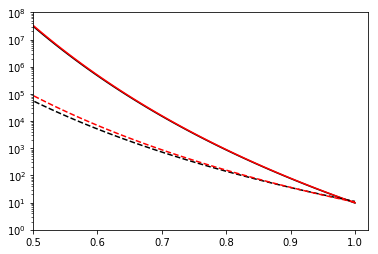

In [14]:
fig, ax = plt.subplots()
ax.plot(tp, prefac*np.exp(etaRef), c = 'k')
ax.plot(tp, prefac*np.exp(etaNew), c = 'r')

ax.plot(tp, prefacLM*np.exp(etaLMRef), c = 'k', ls = '--')
ax.plot(tp, 0.4*prefacLM*np.exp(etaLMNew), c = 'r', ls = '--')

ax.set_ylim(1e0, 1e8)
ax.set_xlim(0.5, 1.02)
ax.set_yscale('log')

In [97]:
Enew, Eref

(27.75670261538461, 27.756703)

In [34]:
alpha

1.0615384615384615

In [ ]:
xs = np.linspace(0, 4*np.pi, 200)
test1 = np.cos(xs) + np.sin(2*xs) + np.random.rand(len(xs))  + 2.5
test2 = np.sin(xs) + np.cos(2*xs) + np.random.rand(len(xs)) + 2.5

In [ ]:
harm = (test1*test2)/(test1 + test2)
harm1 = (1./test1 + 1./test2)**-1.

In [ ]:
plt.plot(xs, test1)
plt.plot(xs, test2)

plt.plot(xs, harm)
plt.plot(xs, harm1, ls = '--')

## Interpolate data to regulat grid

In [ ]:
#
dm = 2/2900.               #grid spacing numoy
inset = 0.99999     #build teh grid just inside the undeworld domain to avoid out of bounds errors
inset_ = 1/inset

minx = -2500./2900.
maxx = 2500.0/2900.
maxy = 2900./2900.
miny = 1. - (1250./2900.)

numx = int((inset*maxx - inset*minx)/dm)
meshxs  = np.linspace(inset*minx, inset*maxx, num=numx, endpoint=True)

numy = int((inset*maxy - inset*miny)/dm)
meshys  = np.linspace((1./inset)*miny, inset*maxy, num=numy, endpoint=True)

xv, yv = np.meshgrid(meshxs, meshys )
#uw just wants an Mx2 array
coords = np.array(zip(xv.flatten(), yv.flatten()))


#interpolate data into our numpy arrays
#these are 1-D

stressdata = scalarField.evaluate(coords[:, :])[:,0] 
tempdata = tempField.evaluate(coords[:, :])[:,0]
#straindata = strainField.evaluate(coords[:, :])[:,0]

#Now create teh 2D arrays and dimensionalaze
stress = np.zeros(xv.shape) 
stress[:] = np.flipud(stressdata.reshape((xv.shape)))*stressScale

temp = np.zeros(xv.shape) 
temp[:] = np.flipud(tempdata.reshape((xv.shape)))*1400.0
stress[temp > 1270] = np.nan


#strain = np.zeros(xv.shape) 
#strain[:] = np.flipud(straindata.reshape((xv.shape)))
#strain = np.clip(strain, -5000, 5000)
#strain[temp > 1270] = np.nan


#save the numpy arrays

#np.savetxt('temp.csv', temp, fmt='%.2f', delimiter=',')
#np.savetxt('stress.csv', stress, fmt='%.2f', delimiter=',')
#np.savetxt('xcoords.csv', xv, fmt='%.2f', delimiter=',')
#np.savetxt('ycoords.csv', yv, fmt='%.2f', delimiter=',')


#testtemp = np.loadtxt('temp.csv', delimiter=',')
#testy = 
#plt.imshow(testtemp)

## check

In [6]:
import pickle

In [7]:
# Load data (deserialize)
with open('../pd.pkl', 'rb') as handle:
    data = pickle.load(handle)

In [8]:
data['']

{'adiabaticTempGrad': <Quantity(0.000369851247601, 'kelvin * kilogram * meter / joule / second ** 2')>,
 'cohesionMantle': <Quantity(20.0, 'megapascal')>,
 'diffusionEnergy': <Quantity(300000.0, 'joule / mole')>,
 'diffusionEnergyDepth': <Quantity(36083.714217, 'kelvin')>,
 'diffusionPreExp': <Quantity(5.34e-10, '1 / pascal / second')>,
 'diffusionVolume': <Quantity(5e-06, 'meter ** 3 / mole')>,
 'diffusionVolumeDepth': <Quantity(0.019449121963, 'kelvin / meter')>,
 'frictionMantle': <Quantity(0.1, 'dimensionless')>,
 'frictionMantleDepth': <Quantity(3234.0, 'kilogram / meter ** 2 / second ** 2')>,
 'gasConstant': <Quantity(8.314, 'joule / kelvin / mole')>,
 'lowerMantleViscFac': <Quantity(5.0, 'dimensionless')>,
 'potentialTemp': <Quantity(1573.0, 'kelvin')>,
 'potentialTemp_': <Quantity(1300.0, 'kelvin')>,
 'refDensity': <Quantity(3300.0, 'kilogram / meter ** 3')>,
 'refDiffusivity': <Quantity(1e-06, 'meter ** 2 / second')>,
 'refExpansivity': <Quantity(3e-05, '1 / kelvin')>,
 'refGr